# Playground Notebook
This notebook is designed as a easy einterface to call the functions that we have defined

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch

from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_participants_info, load_event_descriptions, load_behavioral_data
from LCModels import LCNECortexFCN, LCNECortexRNN, LCNECortexFitter, FeedForwardNN, RecurrentNet

# Untrained Model

Let's defined the two types of models that we have first and run the untrained models

In [2]:
# lambda_cortex = 0.1
# hidden_size = 16

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_FCN = LCNECortexFCN(lambda_cortex).to(device)
# model_RNN = LCNECortexRNN(hidden_size).to(device)

# time_steps = 100
# conditions = ["baseline", "acute_stress", "chronic_stress", "top_down_control"]
# results = {cond: run_simulation(model_FCN, device, time_steps, cond) for cond in conditions}
# render_plot(results)

# Data Preparation
Let's prepare some data first to fit our model. We are specifically using ["Locus coeruleus activity strengthens prioritized memories under arousal"](https://openneuro.org/datasets/ds002011/versions/1.0.0) dataset fror now.

In [3]:
DATASET_PATH = "data"
participants_df = load_participants_info(DATASET_PATH)
load_event_descriptions(DATASET_PATH)

df_behavior = load_behavioral_data(DATASET_PATH, "01")
for idx in range(2,11):
    sample_participant = f"0{idx}"
    df = load_behavioral_data(DATASET_PATH, sample_participant)
    df_behavior = pd.concat([df, df_behavior], ignore_index=True)

Let's preprocess our data first

In [4]:
features = ['Condition', 'PreEvent_PupilMax', 'TrialEvent', 'onset', 'duration']
target = ['Event_PupilDilation']

df_clean = df_behavior[features + target].dropna().reset_index(drop=True)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_clean[['Condition', 'TrialEvent']])
encoded_feature_names = encoder.get_feature_names_out(['Condition', 'TrialEvent'])

scaler_X = StandardScaler()
scaled_features = scaler_X.fit_transform(df_clean[['PreEvent_PupilMax', 'onset', 'duration']])

X_scaled = pd.DataFrame(scaled_features, columns=['PreEvent_PupilMax', 'onset', 'duration'])
X_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names)

X_scaled.reset_index(drop=True, inplace=True)
X_encoded.reset_index(drop=True, inplace=True)
X = pd.concat([X_scaled, X_encoded], axis=1)

# scaler_Y = StandardScaler()
# Y = scaler_Y.fit_transform(df_clean[['Event_PupilDilation']].values.reshape(-1,1))

scaler_Y = MinMaxScaler(feature_range=(-1, 1))
Y = scaler_Y.fit_transform(df_clean[['Event_PupilDilation']].values.reshape(-1, 1))

X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).squeeze()

print(f"X Shape: {X_tensor.shape}, Y Shape: {Y_tensor.shape}")
print(f"Y Min: {Y_tensor.min().item()}, Y Max: {Y_tensor.max().item()}")  # Check Scaling

X Shape: torch.Size([1699, 7]), Y Shape: torch.Size([1699])
Y Min: -1.0, Y Max: 1.0


# Training

## Baseline Fully Connected Neural Network

To illustrate our idea, we want to train 2 models from math and computer science, which is our vanilla feed forward networks and an recurrent networks.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

input_size = X_tensor.shape[1]
model_ff = FeedForwardNN(input_size)
optimizer = optim.Adam(model_ff.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model_ff(X_train)
    loss = loss_fn(Y_pred, Y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.29660746455192566
Epoch 100, Loss: 0.04855722188949585
Epoch 200, Loss: 0.04804303124547005
Epoch 300, Loss: 0.04764094948768616
Epoch 400, Loss: 0.047272779047489166
Epoch 500, Loss: 0.04691353812813759
Epoch 600, Loss: 0.04655757546424866
Epoch 700, Loss: 0.046339597553014755
Epoch 800, Loss: 0.0459541417658329
Epoch 900, Loss: 0.04550493136048317


Let's check the performance of it fitting the data

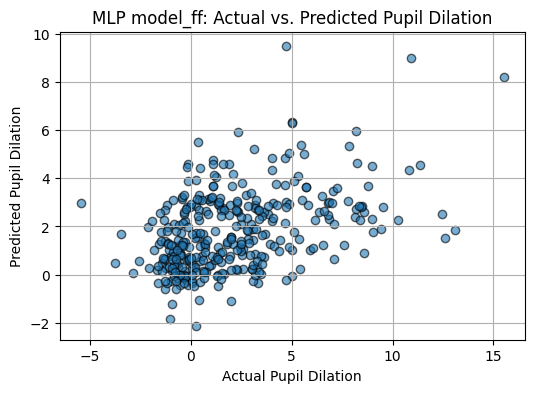

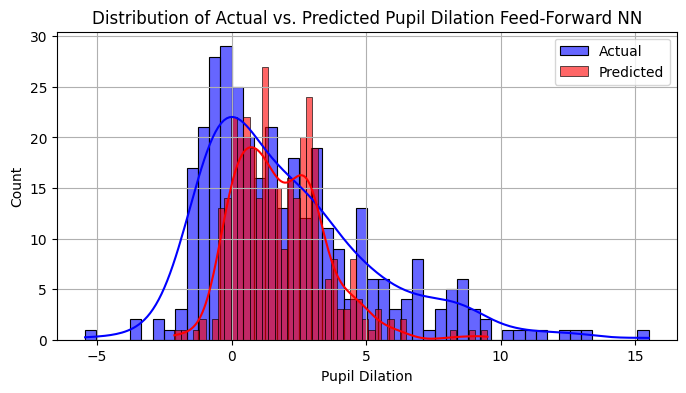

Pearson Correlation: 0.4342


In [6]:
with torch.no_grad():
    Y_test_pred = model_ff(X_test)

Y_test_pred = scaler_Y.inverse_transform(Y_test_pred.cpu().numpy())
Y_test_actual = scaler_Y.inverse_transform(Y_test.cpu().numpy().reshape(-1, 1))

plt.figure(figsize=(6, 4))
plt.scatter(Y_test_actual, Y_test_pred, alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("MLP model_ff: Actual vs. Predicted Pupil Dilation")
plt.grid(True)
plt.show()

df_predictions = pd.DataFrame({'PupilPred': Y_test_pred.flatten()})
df_actual = pd.DataFrame({'Event_PupilDilation': Y_test_actual.flatten()})

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation Feed-Forward NN")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

## Baseline Recurent Networks

We will  do the same thing with an recurrent neural network

In [7]:
# Convert input data into sequences
X_rnn = X_tensor.unsqueeze(1) 
Y_rnn = Y_tensor.unsqueeze(1) 

print(f"X_rnn Shape: {X_rnn.shape}, Y_rnn Shape: {Y_rnn.shape}")

model_rnn = RecurrentNet(input_size=X_rnn.shape[2])
optimizer = optim.Adam(model_rnn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model_rnn(X_rnn)
    loss = loss_fn(Y_pred, Y_rnn)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

X_rnn Shape: torch.Size([1699, 1, 7]), Y_rnn Shape: torch.Size([1699, 1])
Epoch 0, Loss: 0.0687
Epoch 100, Loss: 0.0508
Epoch 200, Loss: 0.0492
Epoch 300, Loss: 0.0485
Epoch 400, Loss: 0.0479
Epoch 500, Loss: 0.0476
Epoch 600, Loss: 0.0475
Epoch 700, Loss: 0.0473
Epoch 800, Loss: 0.0471
Epoch 900, Loss: 0.0470
Epoch 1000, Loss: 0.0469
Epoch 1100, Loss: 0.0467
Epoch 1200, Loss: 0.0467
Epoch 1300, Loss: 0.0466
Epoch 1400, Loss: 0.0465
Epoch 1500, Loss: 0.0464
Epoch 1600, Loss: 0.0464
Epoch 1700, Loss: 0.0464
Epoch 1800, Loss: 0.0466
Epoch 1900, Loss: 0.0463


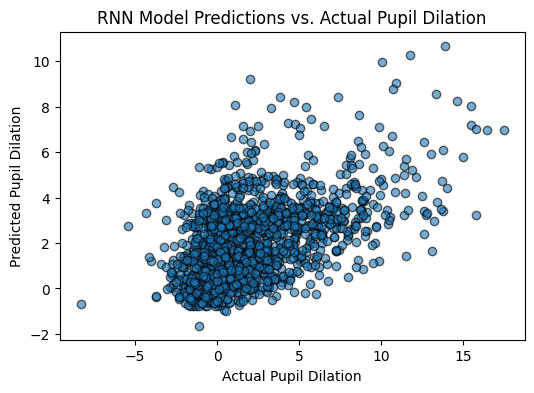

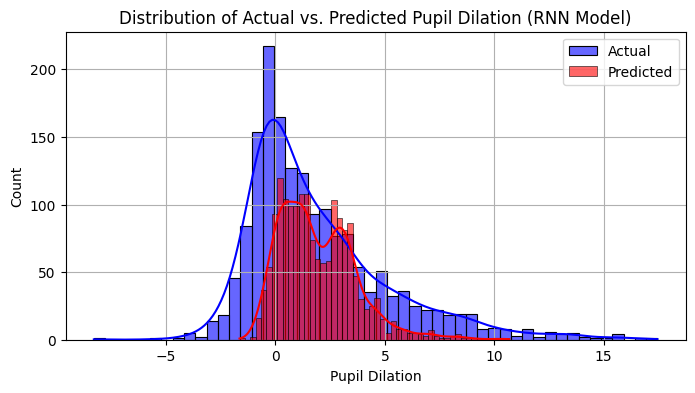

Pearson Correlation: 0.5309


In [28]:
with torch.no_grad():
    Y_pred_rnn = model_rnn(X_rnn)

df_predictions = pd.DataFrame({'PupilPred': scaler_Y.inverse_transform(Y_pred_rnn.cpu().numpy().reshape(-1, 1)).squeeze()})
df_actual = df_clean[['Event_PupilDilation']].reset_index(drop=True)

plt.figure(figsize=(6,4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("RNN Model Predictions vs. Actual Pupil Dilation")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation (RNN Model)")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

## customized LCNECortex Model

Now coming to our customized LCNECortex model

In [9]:
# Initialize model_lc
input_dim = X_tensor.shape[1]  # Dynamically get input feature size
model_lc = LCNECortexFitter(input_dim=input_dim, hidden_dim=8)
optimizer = optim.Adam(model_lc.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.SmoothL1Loss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epochs = 5000
batch_size = 32

for epoch in range(epochs):
    optimizer.zero_grad()

    # Sample a batch of data
    idx = torch.randint(0, X_tensor.shape[0], (batch_size,))
    X_batch, Y_batch = X_tensor[idx], Y_tensor[idx]

    # Initialize LC and Cortex states for batch
    prev_LC = torch.zeros(batch_size, 8)  
    prev_Cortex = torch.zeros(batch_size, 8)  

    # Forward pass
    LC_pred, NE_pred, C_pred, Pupil_pred = model_lc(X_batch, prev_LC, prev_Cortex)

    # Compute loss
    loss = loss_fn(Pupil_pred, Y_batch.unsqueeze(1))

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # scheduler.step(loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


/Users/kevinb/miniforge3/envs/cse251b/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 0.36468827724456787
Epoch 100, Loss: 0.025250142440199852
Epoch 200, Loss: 0.016776034608483315
Epoch 300, Loss: 0.03183644264936447
Epoch 400, Loss: 0.040034182369709015
Epoch 500, Loss: 0.022094905376434326
Epoch 600, Loss: 0.029139619320631027
Epoch 700, Loss: 0.04216684028506279
Epoch 800, Loss: 0.02103234827518463
Epoch 900, Loss: 0.015575408935546875
Epoch 1000, Loss: 0.03555214777588844
Epoch 1100, Loss: 0.022019652649760246
Epoch 1200, Loss: 0.013319414108991623
Epoch 1300, Loss: 0.025060560554265976
Epoch 1400, Loss: 0.021610943600535393
Epoch 1500, Loss: 0.028738850727677345
Epoch 1600, Loss: 0.020449893549084663
Epoch 1700, Loss: 0.03476295992732048
Epoch 1800, Loss: 0.040604595094919205
Epoch 1900, Loss: 0.016265826299786568
Epoch 2000, Loss: 0.03553818538784981
Epoch 2100, Loss: 0.02772766910493374
Epoch 2200, Loss: 0.01823423057794571
Epoch 2300, Loss: 0.020888004451990128
Epoch 2400, Loss: 0.020215604454278946
Epoch 2500, Loss: 0.02803851291537285
Epoch 26

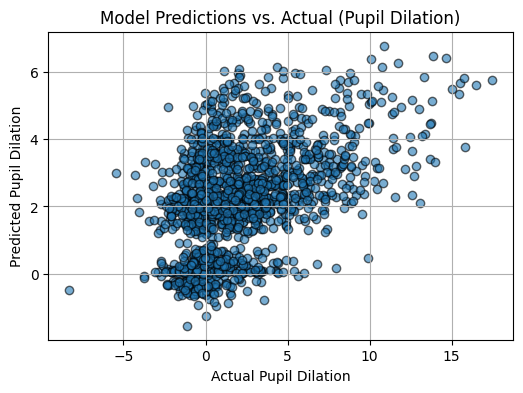

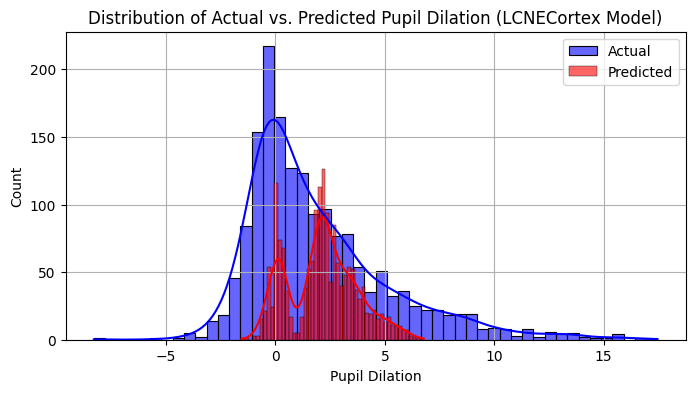

Pearson Correlation: 0.4738


In [10]:
hidden_dim = model_lc.hidden_dim 
batch_size = X_tensor.shape[0]

prev_LC = torch.zeros(batch_size, hidden_dim)  
prev_Cortex = torch.zeros(batch_size, hidden_dim)

with torch.no_grad():
    _, _, _, Pupil_pred = model_lc(X_tensor, prev_LC, prev_Cortex)

df_predictions = pd.DataFrame({'PupilPred': Pupil_pred.squeeze().cpu().numpy()})
df_actual = df_clean[['Event_PupilDilation']].reset_index(drop=True)

if "scaler_Y" in globals():
    # Clip predictions before inverse transformation
    df_predictions['PupilPred'] = np.clip(Pupil_pred.detach().cpu().numpy(), -1, 1)
    df_predictions['PupilPred'] = scaler_Y.inverse_transform(df_predictions[['PupilPred']])


plt.figure(figsize=(6, 4))
plt.scatter(df_actual['Event_PupilDilation'], df_predictions['PupilPred'], alpha=0.6, edgecolors="k")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Predicted Pupil Dilation")
plt.title("Model Predictions vs. Actual (Pupil Dilation)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_actual['Event_PupilDilation'], kde=True, label="Actual", color='blue', alpha=0.6, bins=50)
sns.histplot(df_predictions['PupilPred'], kde=True, label="Predicted", color='red', alpha=0.6, bins=50)

plt.xlabel("Pupil Dilation")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Pupil Dilation (LCNECortex Model)")
plt.grid(True)
plt.show()

corr, _ = pearsonr(df_actual['Event_PupilDilation'], df_predictions['PupilPred'])
print(f"Pearson Correlation: {corr:.4f}")

# Analysis

## Analysis for Feed-Forward Neural Networks

In [11]:
input_size = X_tensor.shape[1]

with torch.no_grad():
    predictions, act1, act2 = model_ff(X_tensor, return_activations=True)

act1_np = act1.cpu().numpy()
act2_np = act2.cpu().numpy()
df_filtered = df_behavior.iloc[:X_tensor.shape[0]].copy()

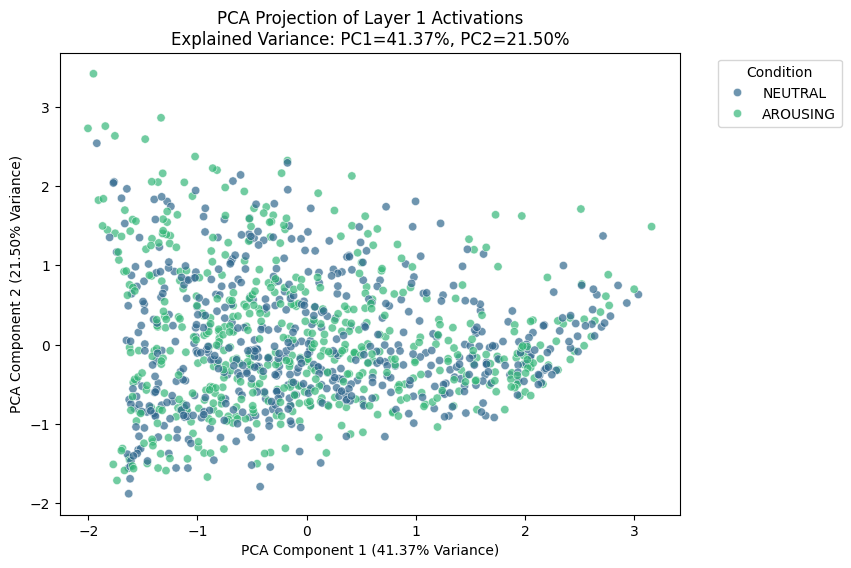

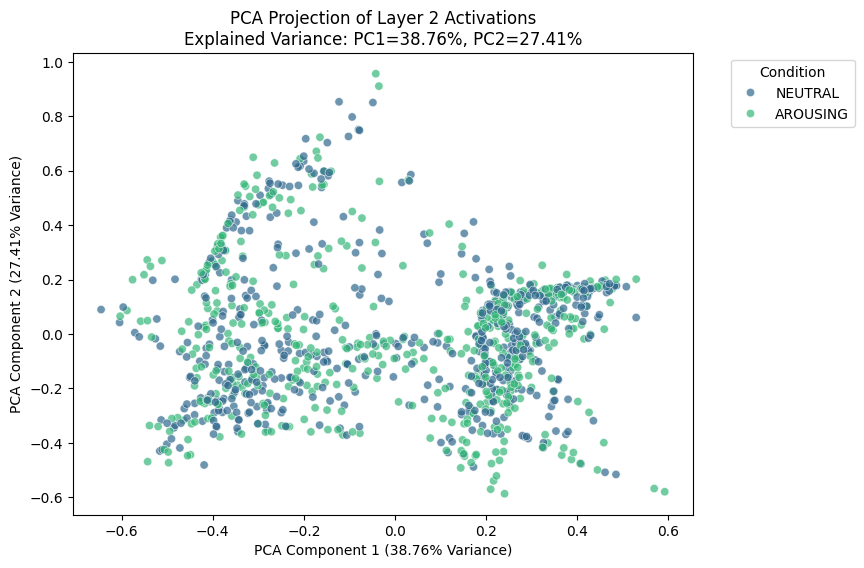

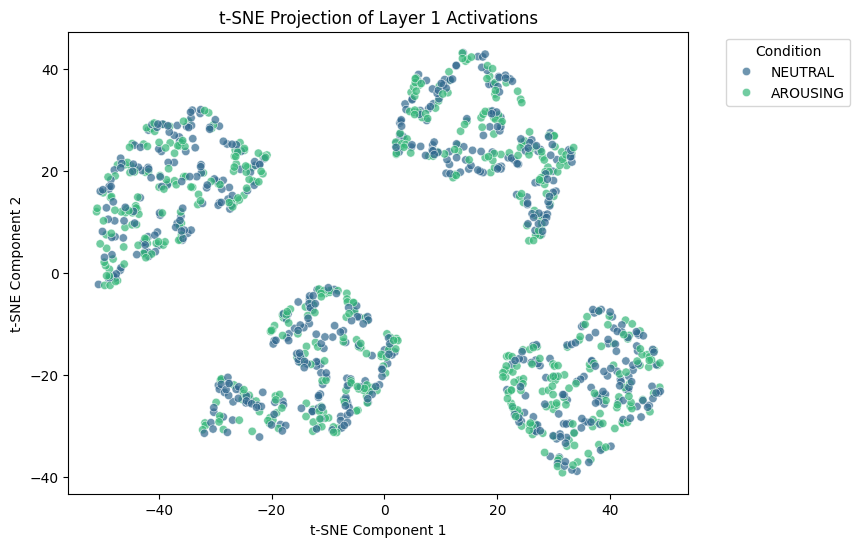

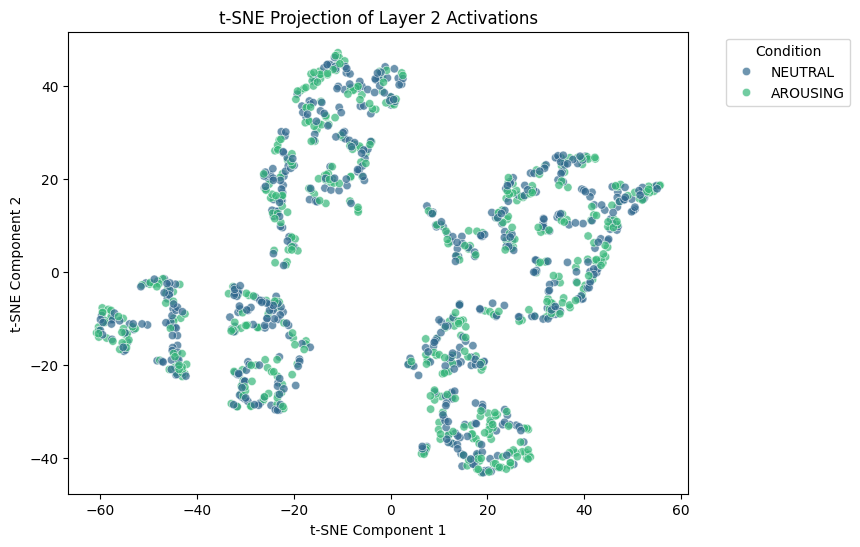

In [12]:
pca1 = PCA(n_components=2)
act1_pca = pca1.fit_transform(act1_np)
explained_variance1 = pca1.explained_variance_ratio_ * 100 

pca2 = PCA(n_components=2)
act2_pca = pca2.fit_transform(act2_np)
explained_variance2 = pca2.explained_variance_ratio_ * 100 

plt.figure(figsize=(8,6))
sns.scatterplot(x=act1_pca[:,0], y=act1_pca[:,1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title(f"PCA Projection of Layer 1 Activations\nExplained Variance: PC1={explained_variance1[0]:.2f}%, PC2={explained_variance1[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance1[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance1[1]:.2f}% Variance)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=act2_pca[:,0], y=act2_pca[:,1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title(f"PCA Projection of Layer 2 Activations\nExplained Variance: PC1={explained_variance2[0]:.2f}%, PC2={explained_variance2[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance2[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance2[1]:.2f}% Variance)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act1_tsne = tsne.fit_transform(act1_np)
act2_tsne = tsne.fit_transform(act2_np)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act1_tsne[:, 0], y=act1_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of Layer 1 Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act2_tsne[:, 0], y=act2_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of Layer 2 Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


## Analysis for Recurrent Networks

In [13]:
with torch.no_grad():
    _, hidden_states = model_rnn.rnn(X_rnn)
    act_rnn = hidden_states.squeeze(0).cpu().numpy()

print(f"RNN Hidden Activations Shape: {act_rnn.shape}")

RNN Hidden Activations Shape: (1699, 32)


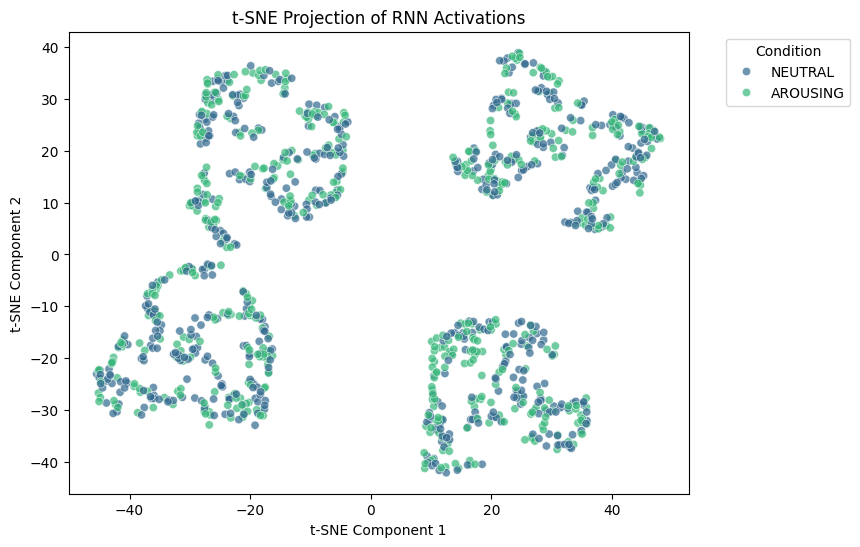

In [14]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_rnn_tsne = tsne.fit_transform(act_rnn)

df_filtered = df_behavior.iloc[:act_rnn.shape[0]].copy()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_rnn_tsne[:, 0], y=act_rnn_tsne[:, 1], hue=df_filtered["Condition"], palette="viridis", alpha=0.7)

plt.title("t-SNE Projection of RNN Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

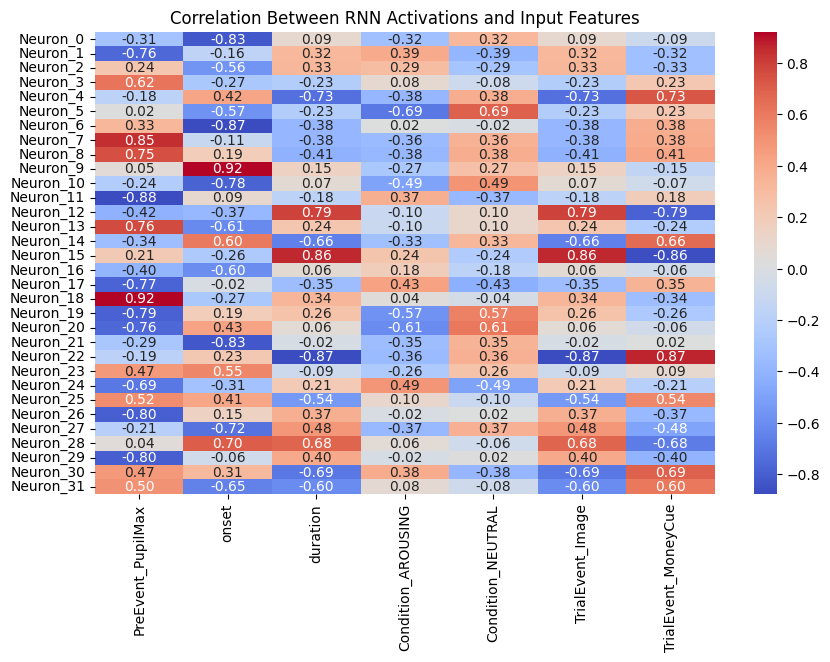

In [15]:
df_activations = pd.DataFrame(act_rnn, columns=[f"Neuron_{i}" for i in range(act_rnn.shape[1])])

df_correlation = pd.concat([df_activations, X], axis=1).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(df_correlation.iloc[:act_rnn.shape[1], act_rnn.shape[1]:], cmap="coolwarm", annot=True, fmt=".2f")

plt.title("Correlation Between RNN Activations and Input Features")
plt.show()

## Analysis for LCNECortex Model

We will see that, though  under fitted with the real data, there are some structureness to the data that we can play around with since we injected mechanistic insights into it.

In [16]:
with torch.no_grad():
    prev_LC = torch.zeros(X_tensor.shape[0], model_lc.hidden_dim)
    prev_Cortex = torch.zeros(X_tensor.shape[0], model_lc.hidden_dim)

    LC_act, NE_act, C_act, Pupil_pred, LC_raw, NE_raw, C_raw = model_lc(X_tensor, prev_LC, prev_Cortex, return_activations=True)

# Convert activations to numpy
act_lc = LC_act.cpu().numpy()
act_ne = NE_act.cpu().numpy()
act_cortex = C_act.cpu().numpy()

# Create DataFrame for analysis
df_activations = pd.DataFrame({
    'LC_Mean': act_lc.mean(axis=1),
    'NE_Mean': act_ne.mean(axis=1),
    'Cortex_Mean': act_cortex.mean(axis=1),
    'PupilPred': Pupil_pred.cpu().numpy().squeeze(),
    'ActualPupil': df_clean['Event_PupilDilation'].values  # Ensure this aligns with X_tensor
})

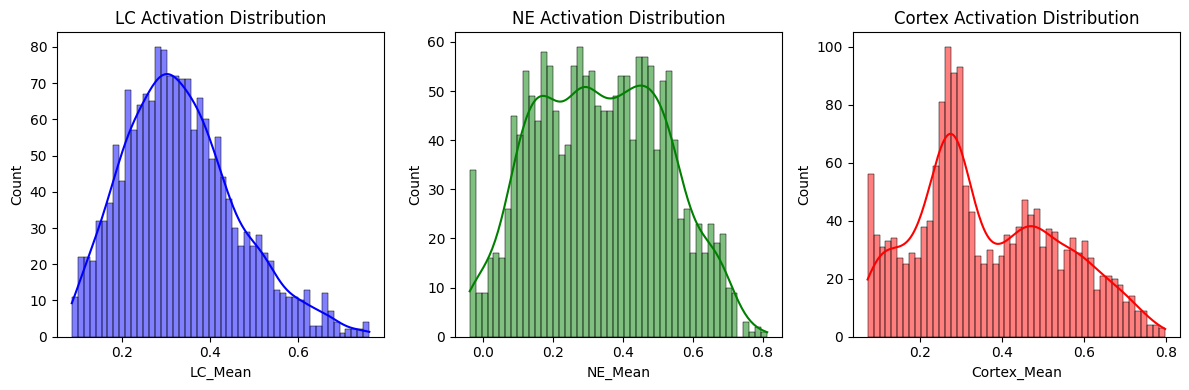

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df_activations['LC_Mean'], kde=True, bins=50, color='blue')
plt.title("LC Activation Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df_activations['NE_Mean'], kde=True, bins=50, color='green')
plt.title("NE Activation Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df_activations['Cortex_Mean'], kde=True, bins=50, color='red')
plt.title("Cortex Activation Distribution")

plt.tight_layout()
plt.show()


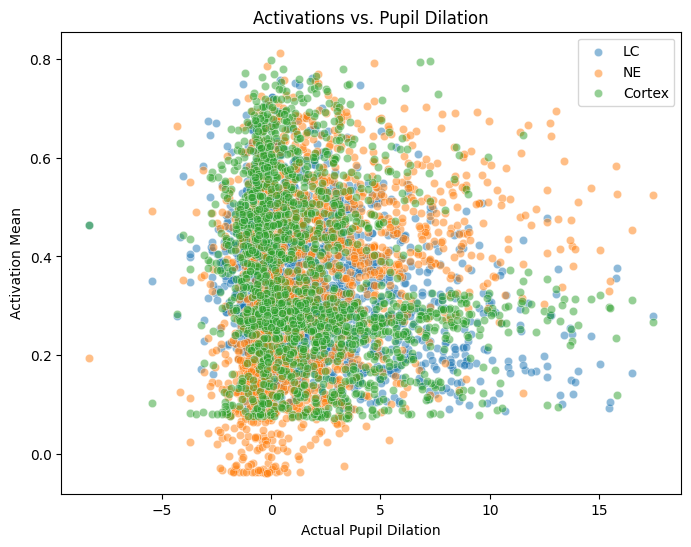

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_activations['ActualPupil'], y=df_activations['LC_Mean'], alpha=0.5, label="LC")
sns.scatterplot(x=df_activations['ActualPupil'], y=df_activations['NE_Mean'], alpha=0.5, label="NE")
sns.scatterplot(x=df_activations['ActualPupil'], y=df_activations['Cortex_Mean'], alpha=0.5, label="Cortex")
plt.xlabel("Actual Pupil Dilation")
plt.ylabel("Activation Mean")
plt.title("Activations vs. Pupil Dilation")
plt.legend()
plt.show()

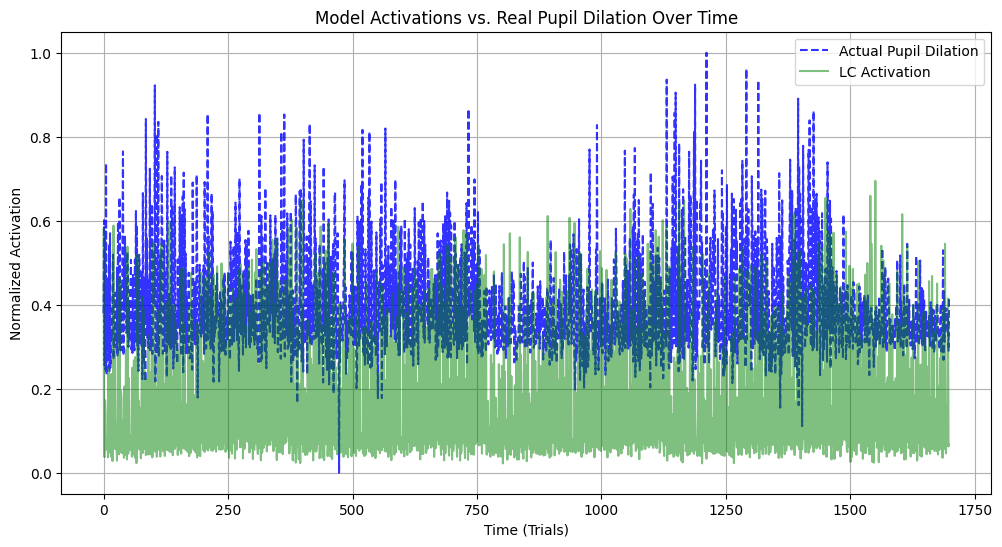

Correlation with Actual Pupil Dilation:
LC Activation: -0.002
NE Activation: 0.013
Cortex Activation: 0.028
Predicted Pupil Dilation: 0.474


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

# Run model to get activations
with torch.no_grad():
    LC_activations, NE_activations, C_activations, Pupil_pred = model_lc(
        X_tensor, torch.zeros(X_tensor.shape[0], 8), torch.zeros(X_tensor.shape[0], 8)
    )

# Convert to NumPy for plotting
act_lc = LC_activations.cpu().numpy().squeeze()
act_ne = NE_activations.cpu().numpy().squeeze()
act_cortex = C_activations.cpu().numpy().squeeze()
pupil_pred = Pupil_pred.cpu().numpy().squeeze()

# Extract actual pupil dilation from dataset
pupil_actual = df_clean["Event_PupilDilation"].values
time_axis = np.arange(len(pupil_actual))  # Time index

# Fit MinMaxScaler for EACH variable separately
scaler_pupil = MinMaxScaler(feature_range=(0, 1))
pupil_actual_scaled = scaler_pupil.fit_transform(pupil_actual.reshape(-1, 1)).squeeze()
pupil_pred_scaled = scaler_pupil.transform(pupil_pred.reshape(-1, 1)).squeeze()

scaler_lc = MinMaxScaler(feature_range=(0, 1))
act_lc_scaled = scaler_lc.fit_transform(act_lc.reshape(-1, 1)).squeeze()

scaler_ne = MinMaxScaler(feature_range=(0, 1))
act_ne_scaled = scaler_ne.fit_transform(act_ne.reshape(-1, 1)).squeeze()

scaler_cortex = MinMaxScaler(feature_range=(0, 1))
act_cortex_scaled = scaler_cortex.fit_transform(act_cortex.reshape(-1, 1)).squeeze()

# Ensure all variables have the same length
min_length = min(len(time_axis), len(pupil_actual_scaled), len(pupil_pred_scaled), 
                 len(act_lc_scaled), len(act_ne_scaled), len(act_cortex_scaled))

time_axis = time_axis[:min_length]
pupil_actual_scaled = pupil_actual_scaled[:min_length]
pupil_pred_scaled = pupil_pred_scaled[:min_length]
act_lc_scaled = act_lc_scaled[:min_length]
act_ne_scaled = act_ne_scaled[:min_length]
act_cortex_scaled = act_cortex_scaled[:min_length]


plt.figure(figsize=(12, 6))

sns.lineplot(x=time_axis, y=pupil_actual_scaled, label="Actual Pupil Dilation", color='blue', linestyle="dashed", alpha=0.8)
sns.lineplot(x=time_axis, y=act_lc_scaled, label="LC Activation", color='green', alpha=0.5)
# sns.lineplot(x=time_axis, y=act_ne_scaled, label="NE Activation", color='purple', alpha=0.5)
# sns.lineplot(x=time_axis, y=act_cortex_scaled, label="Cortex Activation", color='orange', alpha=0.5)

plt.xlabel("Time (Trials)")
plt.ylabel("Normalized Activation")
plt.title("Model Activations vs. Real Pupil Dilation Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Compute Pearson correlations
lc_corr = pearsonr(act_lc_scaled, pupil_actual_scaled)[0]
ne_corr = pearsonr(act_ne_scaled, pupil_actual_scaled)[0]
cortex_corr = pearsonr(act_cortex_scaled, pupil_actual_scaled)[0]
pupil_pred_corr = pearsonr(pupil_pred_scaled, pupil_actual_scaled)[0]
print(f"Correlation with Actual Pupil Dilation:")
print(f"LC Activation: {lc_corr:.3f}")
print(f"NE Activation: {ne_corr:.3f}")
print(f"Cortex Activation: {cortex_corr:.3f}")
print(f"Predicted Pupil Dilation: {pupil_pred_corr:.3f}")

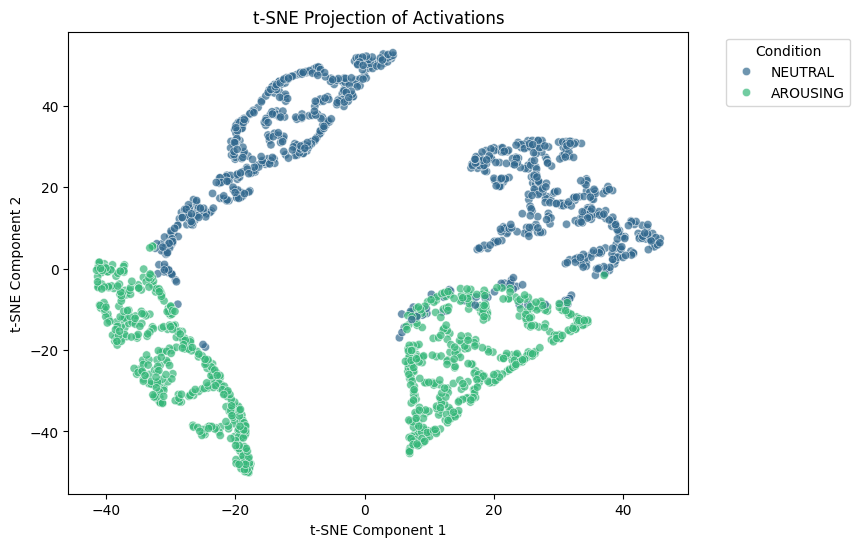

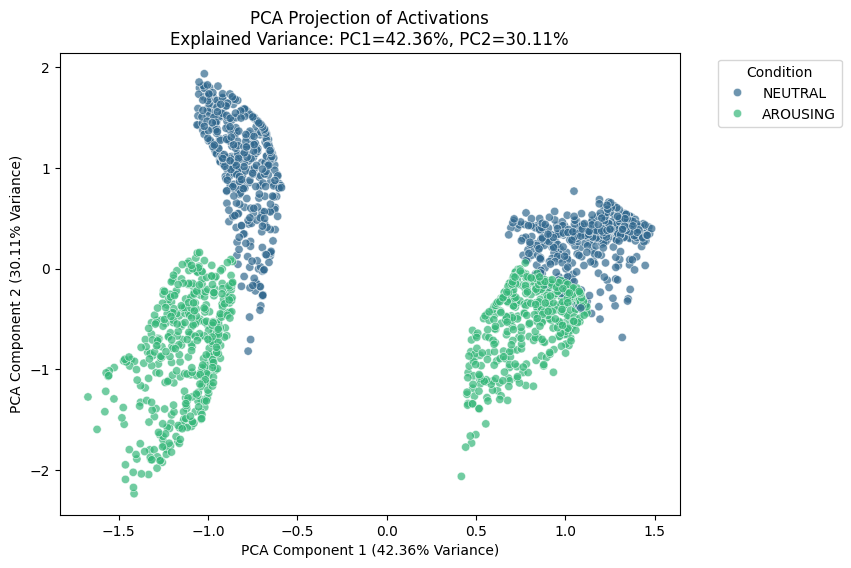

In [27]:
# Concatenate activations
act_combined = np.hstack([act_lc])

pca = PCA(n_components=2)
act_pca = pca.fit_transform(act_combined)
explained_variance = pca.explained_variance_ratio_ * 100

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_tsne = tsne.fit_transform(act_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_tsne[:, 0], y=act_tsne[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_pca[:, 0], y=act_pca[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7)
plt.title(f"PCA Projection of Activations\nExplained Variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance[1]:.2f}% Variance)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

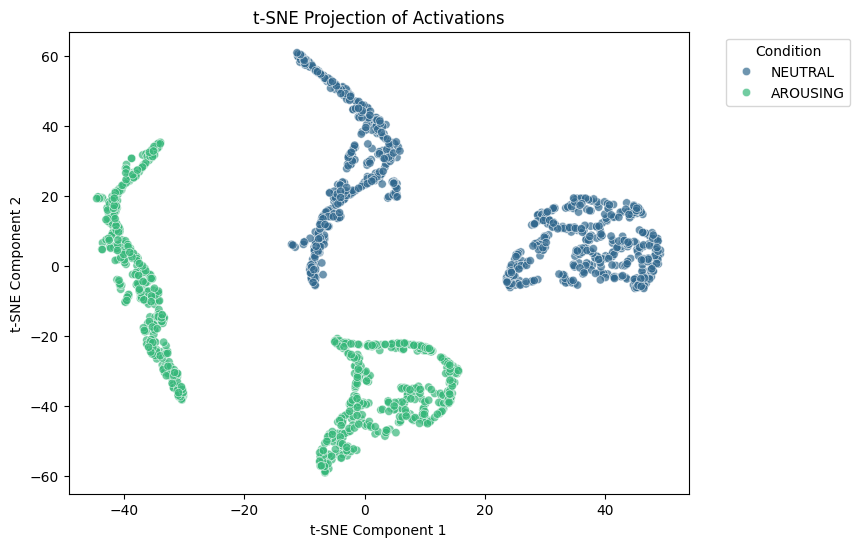

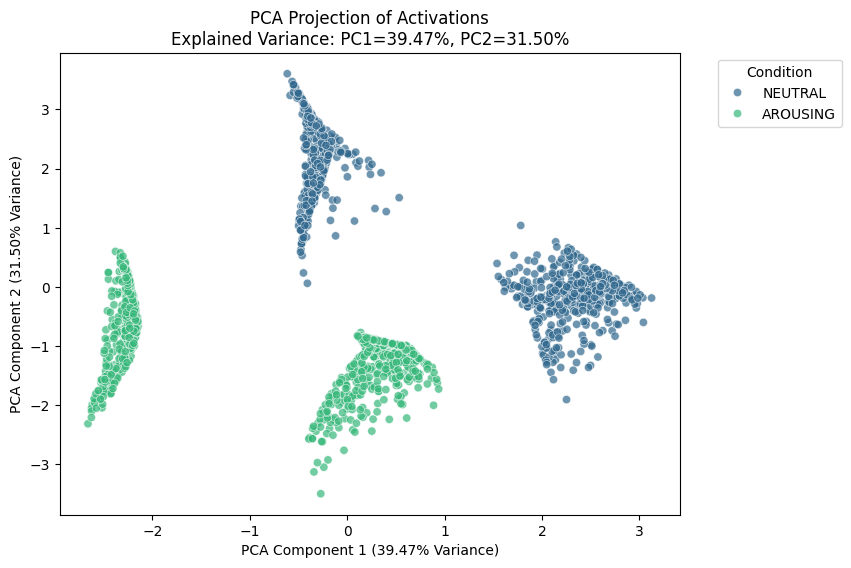

In [22]:
# Concatenate activations
act_combined = np.hstack([act_lc, act_ne, act_cortex])

pca = PCA(n_components=2)
act_pca = pca.fit_transform(act_combined)
explained_variance = pca.explained_variance_ratio_ * 100

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_tsne = tsne.fit_transform(act_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_tsne[:, 0], y=act_tsne[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7)
plt.title("t-SNE Projection of Activations")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_pca[:, 0], y=act_pca[:, 1], hue=df_clean["Condition"], palette="viridis", alpha=0.7)
plt.title(f"PCA Projection of Activations\nExplained Variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance[1]:.2f}% Variance)")
plt.legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

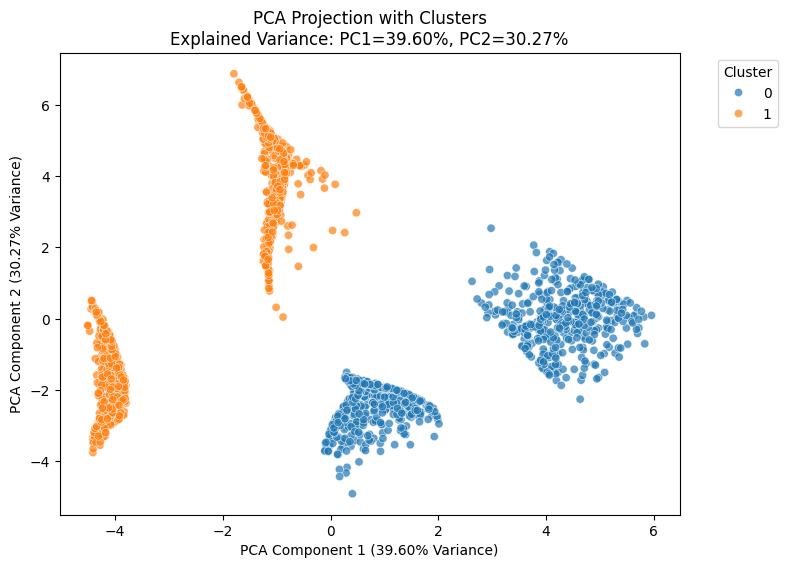

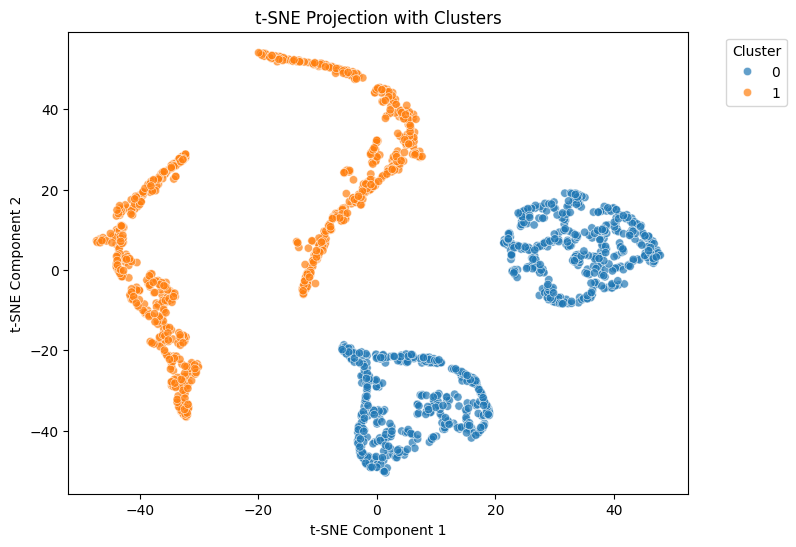

In [20]:
scaler = StandardScaler()
act_combined = scaler.fit_transform(np.hstack([act_lc, act_ne, act_cortex]))

pca = PCA(n_components=2)
act_pca = pca.fit_transform(act_combined)
explained_variance = pca.explained_variance_ratio_ * 100

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
act_tsne = tsne.fit_transform(act_pca)

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters_pca = kmeans.fit_predict(act_pca)
clusters_tsne = kmeans.predict(act_tsne)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_pca[:, 0], y=act_pca[:, 1], hue=clusters_pca, palette="tab10", alpha=0.7)
plt.title(f"PCA Projection with Clusters\nExplained Variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%")
plt.xlabel(f"PCA Component 1 ({explained_variance[0]:.2f}% Variance)")
plt.ylabel(f"PCA Component 2 ({explained_variance[1]:.2f}% Variance)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=act_tsne[:, 0], y=act_tsne[:, 1], hue=clusters_tsne, palette="tab10", alpha=0.7)
plt.title("t-SNE Projection with Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()